In [20]:
import numpy as np
from obspy import UTCDateTime
import obspy as obs
from obspy.clients.fdsn import Client as FDSN_Client
import numpy as np
from matplotlib import pyplot as plt
import sys
from ground_motion_qh import extract_pairs
from ground_motion_qh.catalog import Catalog
from ground_motion_qh.earthquake import EarthquakeCatalog
# import earthquake import EarthquakeCatalog
from pathlib import Path
from ground_motion_qh.get_waveforms import get_stream_multiple_stations, raw_stream_to_amplitude_and_times

    

In [37]:
earquake_metadata = {
    "starttime": '2000-01-01',
    "endtime": '2023-01-01',
    "latitude_range": [33,34],
    "longitude_range": [-117,-116],
    "minimum_magnitude": 4.5, 
}

station_metadata = dict(
    stname = ["SND"],
    network = "AZ",
    org = "IRIS",
)

In [38]:
earthquakes = EarthquakeCatalog(
    filename="local_catalog.csv",
    kwargs=earquake_metadata,
)

/Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/GroundMotion_QH/ground_motion_qh/earthquake.py:196: UserWarning: Reloading local_catalog.csv
  warnings.warn(f"Reloading {filename}")


<Axes: xlabel='Time', ylabel='mag'>

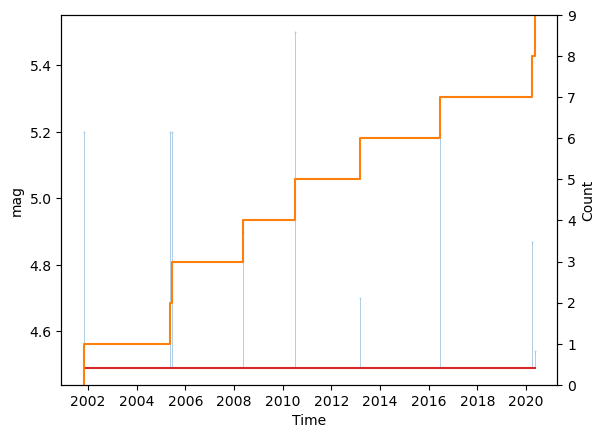

In [39]:
earthquakes.plot_time_series()

In [43]:
event_time_window = 30 # seconds (also we refer to this as tw-)
buffer = 0
forecast_time_window = 10*60 # seconds (also we refer to this as tw+)


In [ ]:
A_pre = []
A_post = []

for i, t0 in enumerate(earthquakes.catalog.time):
    print(f"Dowloading event {i}")
    
    try:
        stream_dict = get_stream_multiple_stations(
            t1=UTCDateTime(t0),
            t2=UTCDateTime(t0 + np.timedelta64(event_time_window, "s")),
        )
        a_trigger, _ = raw_stream_to_amplitude_and_times(stream_dict["SND"])

        stream_dict = get_stream_multiple_stations(
            t1=UTCDateTime(t0 + np.timedelta64(event_time_window + buffer, "s")),
            t2=UTCDateTime(t0 + np.timedelta64(event_time_window + buffer + forecast_time_window, "s")),
        )
        a_forecast, _ = raw_stream_to_amplitude_and_times(stream_dict["SND"])
        
        A_pre.append(a_trigger)
        A_post.append(a_forecast)
        
    except Exception as e:
        print(f"Error dowloading event {i}: {e}")
        A_pre.append(np.array([]))
        A_post.append(np.array([]))
        
        continue

Dowloading event 0
Dowloading event 1
Dowloading event 2
Dowloading event 3
Dowloading event 4
Dowloading event 5
Dowloading event 6
Dowloading event 7
Error dowloading event 7: No data available for request.
HTTP Status code: 204
Detailed response of server:


Dowloading event 8


In [45]:
a_forecast_max = np.array([np.max(np.abs(a-np.mean(a))) for a in A_post])
a_trigger_max = np.array([np.max(np.abs(a-np.mean(a))) for a in A_pre])


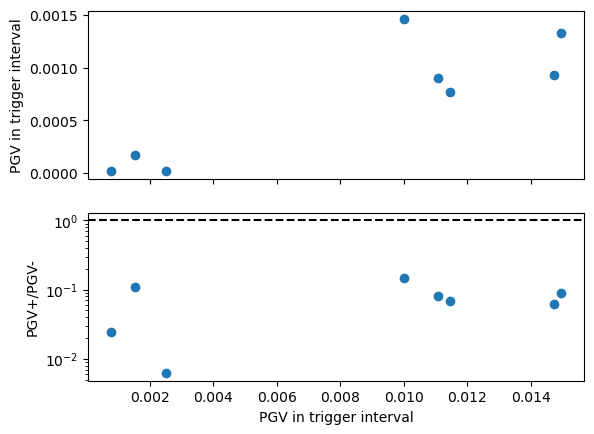

In [56]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].scatter(a_trigger_max, a_forecast_max)
ax[0].set(
    ylabel="PGV in trigger interval",
)

ax[1].scatter(a_trigger_max, a_forecast_max/a_trigger_max)
ax[1].set(
    xlabel="PGV in trigger interval",
    ylabel="PGV+/PGV-",
    yscale="log",
)
ax[1].axhline(1, color="k", linestyle="--")
